In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import copy
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLS
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV 
import re
import os

%matplotlib inline

print(os.listdir("../input"))

['train_V2.csv', 'test_V2.csv', 'sample_submission_V2.csv']


In [4]:
train_df = pd.read_csv("../input/train_V2.csv")
test_df = pd.read_csv("../input/test_V2.csv")
print(train_df.shape, test_df.shape)

(4446966, 29) (1934174, 28)


In [5]:
train_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [6]:
train_df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [7]:
groupsize = train_df.groupby("matchType").size().reset_index()
groupsize.columns = ["matchType","percentage"]
groupsize.percentage = groupsize.percentage / groupsize.percentage.sum() * 100

In [8]:
train_df.groupby("matchType").size()

matchType
crashfpp               6287
crashtpp                371
duo                  313591
duo-fpp              996691
flarefpp                718
flaretpp               2505
normal-duo              199
normal-duo-fpp         5489
normal-solo             326
normal-solo-fpp        1682
normal-squad            516
normal-squad-fpp      17174
solo                 181943
solo-fpp             536762
squad                626526
squad-fpp           1756186
dtype: int64

In [9]:
test_df.groupby("matchType").size()

matchType
crashfpp              2701
crashtpp               178
duo                 140935
duo-fpp             441667
flarefpp               137
flaretpp               634
normal-duo               8
normal-duo-fpp        1676
normal-solo             58
normal-solo-fpp         99
normal-squad           186
normal-squad-fpp      4161
solo                 77989
solo-fpp            235778
squad               275830
squad-fpp           752137
dtype: int64

In [10]:
groupsize_test = test_df.groupby("matchType").size().reset_index()
groupsize_test.columns = ["matchType","percentage_test"]
groupsize_test.percentage_test = groupsize_test.percentage_test / groupsize_test.percentage_test.sum() * 100

In [11]:
groupsize = pd.merge(groupsize, groupsize_test)

In [12]:
standard_mode = ["solo", "duo", "squad", "solo-fpp","duo-fpp", "squad-fpp"]

In [13]:
groupsize[groupsize.matchType.isin(standard_mode)][["percentage", "percentage_test"]].sum()

percentage         99.206942
percentage_test    99.491359
dtype: float64

Treat only standard mode as solo,duo,squad(seems like tpp) and solo-fpp,duo-fpp, squad-fpp

In [15]:
train_df = train_df[train_df.matchType.isin(standard_mode)]

In [16]:
train_df.isnull().sum(axis=0)

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [17]:
test_df.isnull().sum(axis=0)

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
dtype: int64

Missing value exist in winPlacePerc

In [18]:
train_df[np.isnan(train_df.winPlacePerc)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0,0.0,9,solo-fpp,1,1,1574,0,0.0,0,0.0,0,0,0.0,0,0,NaN


I think that it doesn't have any meaningful data, so drop this object in train_df

In [19]:
nan_index = train_df[np.isnan(train_df.winPlacePerc)].index
train_df=train_df.drop(nan_index, axis =0)

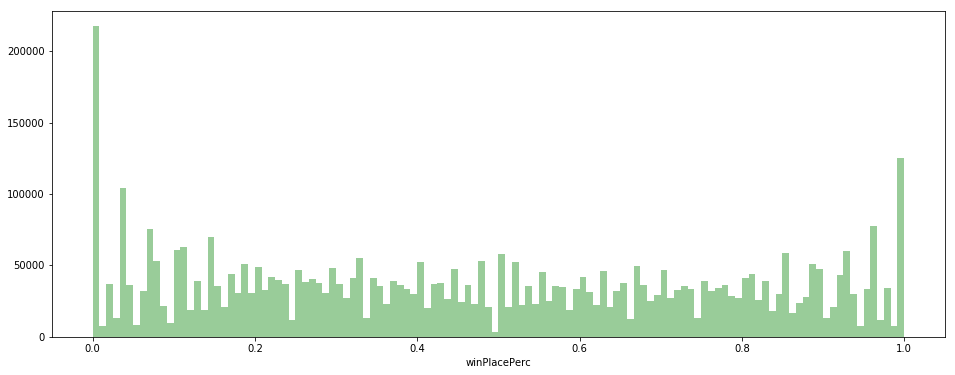

In [20]:
fig = plt.figure(figsize = (16,6))
sns.distplot(train_df["winPlacePerc"], kde = False, color = 'green', bins=120)

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4411698 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 1009.8+ MB


In [22]:
numeric_features = train_df.select_dtypes(exclude = ["object"]).columns.tolist()

In [23]:
train_df.select_dtypes(include = ["object"]).head()

,Id,groupId,matchId,matchType
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,squad-fpp
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,squad-fpp
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,duo
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,squad-fpp
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,solo-fpp


In [24]:
train_df[["Id"]].duplicated().unique()

array([False])

There is no duplicated ID

In [25]:
train_df[numeric_features].nunique()

assists               12
boosts                27
damageDealt        29480
DBNOs                 29
headshotKills         22
heals                 63
killPlace            100
killPoints          1707
kills                 28
killStreaks           17
longestKill        28205
matchDuration       1035
maxPlace              98
numGroups             99
rankPoints          2262
revives               25
rideDistance       33461
roadKills             14
swimDistance       28316
teamKills              5
vehicleDestroys        6
walkDistance       38569
weaponsAcquired       70
winPoints           1447
winPlacePerc        3000
dtype: int64

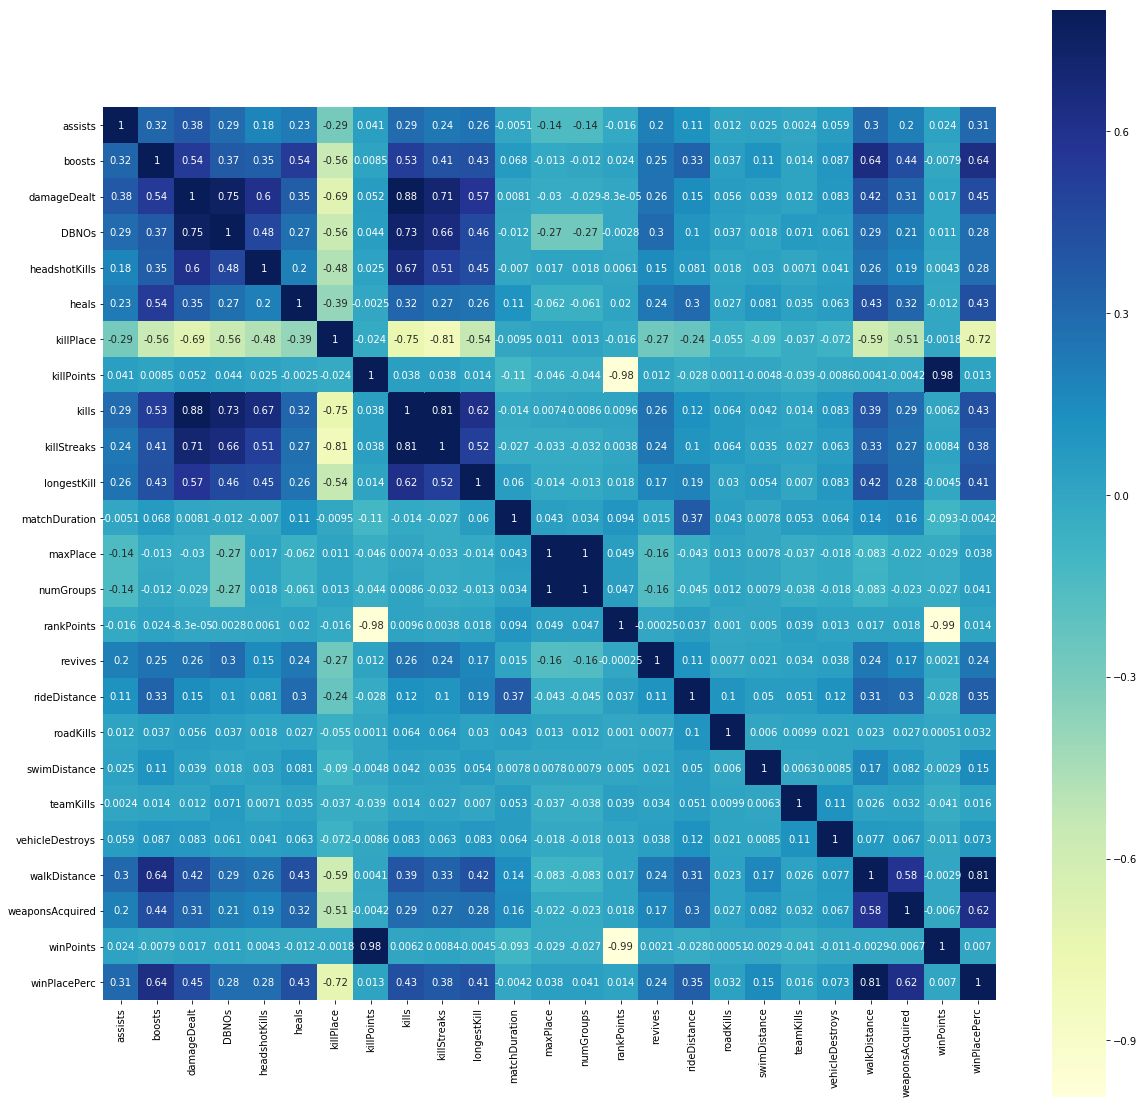

In [26]:
corr = train_df[numeric_features].corr()
f, ax = plt.subplots(figsize = (20,20))

sns.heatmap(corr, vmax=.8, cmap = 'YlGnBu', annot = True, square=True)

Since match duration is same value for same matchId,and it has no relation with target value  
So, drop this feature in train_df

In [27]:
train_df = train_df.drop(["matchDuration"], axis=1)

maxPlace and numGroups have same definition, so the correlation calculated as 1, but some cases, maxPlace is larger than numGroups
Also, winPlacePerc is calculated by maxPlace, not numGroups. So I'll drop numGroups in train_df

In [28]:
train_df = train_df.drop(["numGroups"], axis =1)

In [29]:
numeric_features.remove("numGroups")
numeric_features.remove("matchDuration")

In [30]:
train_df.shape

(4411698, 27)

In [34]:
train_df[(train_df.kills == 0 ) & (train_df.winPlacePerc == 1) & (train_df.matchType.isin(["solo","solo-fpp"]))][["matchType"]].groupby("matchType").size()

matchType
solo        936
solo-fpp      5
dtype: int64

In [35]:
zero_kill_winner = train_df[(train_df.kills == 0 ) & (train_df.winPlacePerc == 1) & (train_df.matchType.isin(["solo","solo-fpp"]))].index

In [36]:
train_df = train_df.drop(zero_kill_winner, axis=0)

0-kill winners in Solo or Solo-fpp are created by error or very very rare case  
So drop them in train_df

In [ ]:
groupsize_test = test_df.groupby("matchType").size().reset_index()
groupsize_test.columns = ["matchType","percentage_test"]
groupsize_test.percentage_test = groupsize_test.percentage_test / groupsize_test.percentage_test.sum() * 100

In [ ]:
kills_perc = train_df[["kills"]].groupby("kills").size().reset_index()
kills_perc.columns = ["kills", "kill_perc"]
kills_perc.kill_perc = kills_perc.kill_perc / kills_perc.kill_perc.sum() * 100

In [ ]:
kills_perc["cumulative_perc"] = kills_perc.kill_perc.cumsum()

In [37]:
kills_perc

,kills,kill_perc,cumulative_perc
0,0,56.980487,56.980487
1,1,20.899731,77.880218
2,2,10.632505,88.512722
3,3,5.219555,93.732277
4,4,2.791646,96.523923
5,5,1.484916,98.008839
6,6,0.840697,98.849536
7,7,0.479045,99.328581
8,8,0.275835,99.604415
9,9,0.162160,99.766575


In [38]:
group_kills = train_df[["groupId","matchId", "kills"]].groupby(["groupId","matchId"]).sum().reset_index()

In [39]:
group_kills.columns=["groupId","matchId","groupKills"]

In [40]:
train_df = pd.DataFrame.merge(train_df, group_kills, on=["groupId","matchId"])

In [41]:
gc.collect()

123

In [42]:
duplicate_groupid = train_df[(train_df.matchType.isin(["solo","solo-fpp"]))&(train_df.kills != train_df.groupKills)].groupId.unique().tolist()

In [43]:
train_df[train_df.groupId=="a533f21e0d9e98"][["groupId","matchId","kills","matchType"]]

,groupId,matchId,kills,matchType
1294,a533f21e0d9e98,426c567e2d5c9e,1,solo
1295,a533f21e0d9e98,426c567e2d5c9e,0,solo
1296,a533f21e0d9e98,426c567e2d5c9e,0,solo


How they have same groupId and matchId in solo type match???

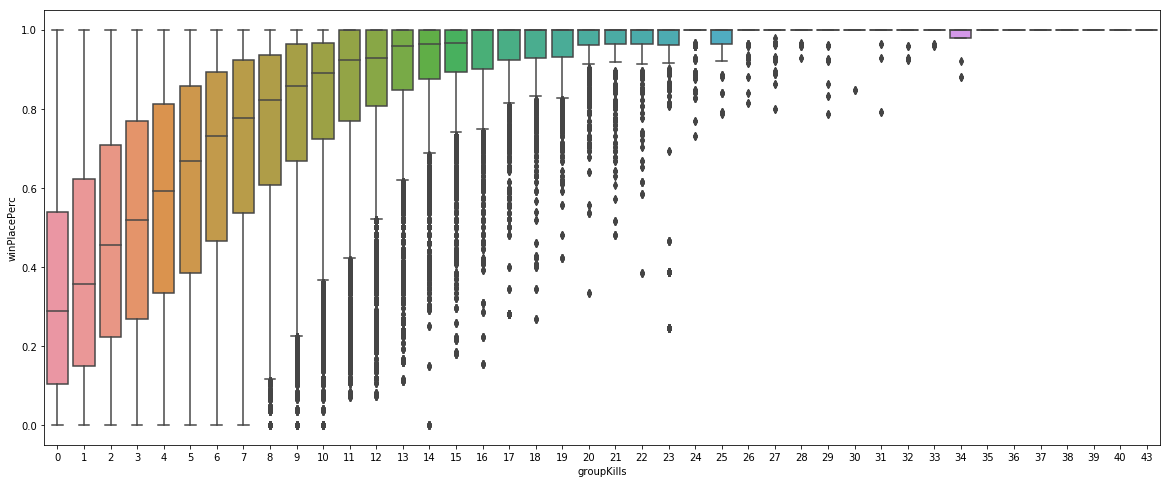

In [44]:
plt.figure(figsize=(20,8))
sns.boxplot(x="groupKills", y="winPlacePerc", data=train_df)

Make some features by 'kills' in train_df

In [45]:
train_solo = train_df[train_df.matchType.isin(["solo","solo-fpp"])]
train_not_solo = train_df[~train_df.matchType.isin(["solo","solo-fpp"])]

In [46]:
test_solo_index = test_df[test_df.matchType.apply(lambda matchtype : bool(re.search("solo", matchtype)))].index
test_not_solo_index = test_df[~test_df.matchType.apply(lambda matchtype : bool(re.search("solo", matchtype)))].index

In [47]:
test_solo = test_df.iloc[test_solo_index,]
test_not_solo = test_df.iloc[test_not_solo_index,]

In [48]:
min_kills = train_not_solo[["groupId", "matchId","kills"]].groupby(["groupId","matchId"]).min().reset_index()
max_kills = train_not_solo[["groupId", "matchId","kills"]].groupby(["groupId","matchId"]).max().reset_index()
mean_kills = train_not_solo[["groupId", "matchId","kills"]].groupby(["groupId","matchId"]).mean().reset_index()

In [49]:
test_mean_kills = test_not_solo[["groupId", "matchId","kills"]].groupby(["groupId","matchId"]).mean().reset_index()

In [50]:
min_kills.columns = ["groupId","matchId","min_kills"]
max_kills.columns = ["groupId","matchId","max_kills"]
mean_kills.columns = ["groupId","matchId","mean_kills"]

In [51]:
test_mean_kills.columns = ["groupId","matchId","mean_kills"]

In [52]:
tmp_df = copy.deepcopy(train_solo)
test_tmp_df = copy.deepcopy(test_solo)

In [53]:
tmp_df["mean_kills"] = train_solo.kills
tmp_df["min_kills"] = train_solo.kills
tmp_df["max_kills"] = train_solo.kills

In [54]:
test_tmp_df["mean_kills"] =  test_solo.kills

In [55]:
kills_df = pd.DataFrame.merge(min_kills,max_kills,on=min_kills.columns[:-1].tolist())
kills_df = pd.DataFrame.merge(kills_df, mean_kills, on=min_kills.columns[:-1].tolist())

In [56]:
kills_df.head()

,groupId,matchId,min_kills,max_kills,mean_kills
0,00000c08b5be36,660d439a723670,0,1,0.666667
1,00000d1cbbc340,370b420efc87f4,1,1,1.000000
2,000038ec4dff53,77a20700ee0c75,1,3,2.000000
3,00003a54230763,5ff11bb177a286,0,1,0.500000
4,000049feba5c83,789a6f3b30fb8b,0,2,1.000000


In [57]:
train_not_solo = pd.merge(train_not_solo, kills_df, on = ["groupId","matchId"])

In [58]:
test_not_solo = pd.merge(test_not_solo, test_mean_kills, on = ["groupId","matchId"])

In [59]:
train_df = train_not_solo.append(tmp_df, sort=True)
test_df = test_not_solo.append(test_tmp_df, sort=True)

In [60]:
print(train_df.shape, test_df.shape)

(4410757, 31) (1934174, 29)


In [61]:
del [[train_not_solo, train_solo, tmp_df, kills_df, test_not_solo, test_solo, test_tmp_df, test_mean_kills]]
gc.collect()

109

In [62]:
train_df[["kills","killStreaks","min_kills","mean_kills","max_kills","groupKills","winPlacePerc"]].corr()

,kills,killStreaks,min_kills,mean_kills,max_kills,groupKills,winPlacePerc
kills,1.000000,0.813986,0.622481,0.792786,0.697496,0.643331,0.431963
killStreaks,0.813986,1.000000,0.442878,0.608470,0.550371,0.533448,0.378395
min_kills,0.622481,0.442878,1.000000,0.785181,0.455780,0.390265,0.370614
mean_kills,0.792786,0.608470,0.785181,1.000000,0.879804,0.811481,0.544868
max_kills,0.697496,0.550371,0.455780,0.879804,1.000000,0.911638,0.488858
groupKills,0.643331,0.533448,0.390265,0.811481,0.911638,1.000000,0.461158
winPlacePerc,0.431963,0.378395,0.370614,0.544868,0.488858,0.461158,1.000000


mean_kills is mostly related with target variable and they have strong muiticolinearlit. So, drop other features about kill

In [63]:
train_df = train_df.drop(["kills","killStreaks","min_kills","max_kills","groupKills"], axis=1)

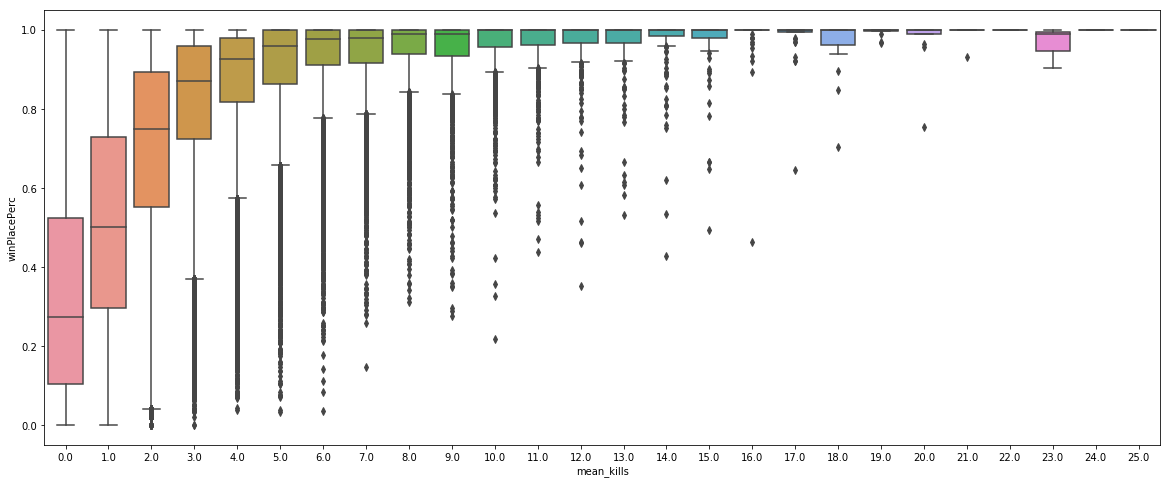

In [64]:
plt.figure(figsize=(20,8))
sns.boxplot(x=np.round(train_df.mean_kills), y=train_df.winPlacePerc)

In [65]:
column_order = ['DBNOs', 'Id', 'assists', 'boosts', 'damageDealt', 'groupId',
       'headshotKills', 'heals', 'killPlace', 'killPoints',
       'longestKill', 'matchId', 'matchType', 'maxPlace',
       'mean_kills', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc']
train_df = train_df[column_order]

In [66]:
numeric_features = train_df.select_dtypes(exclude = ["object"]).columns.tolist()

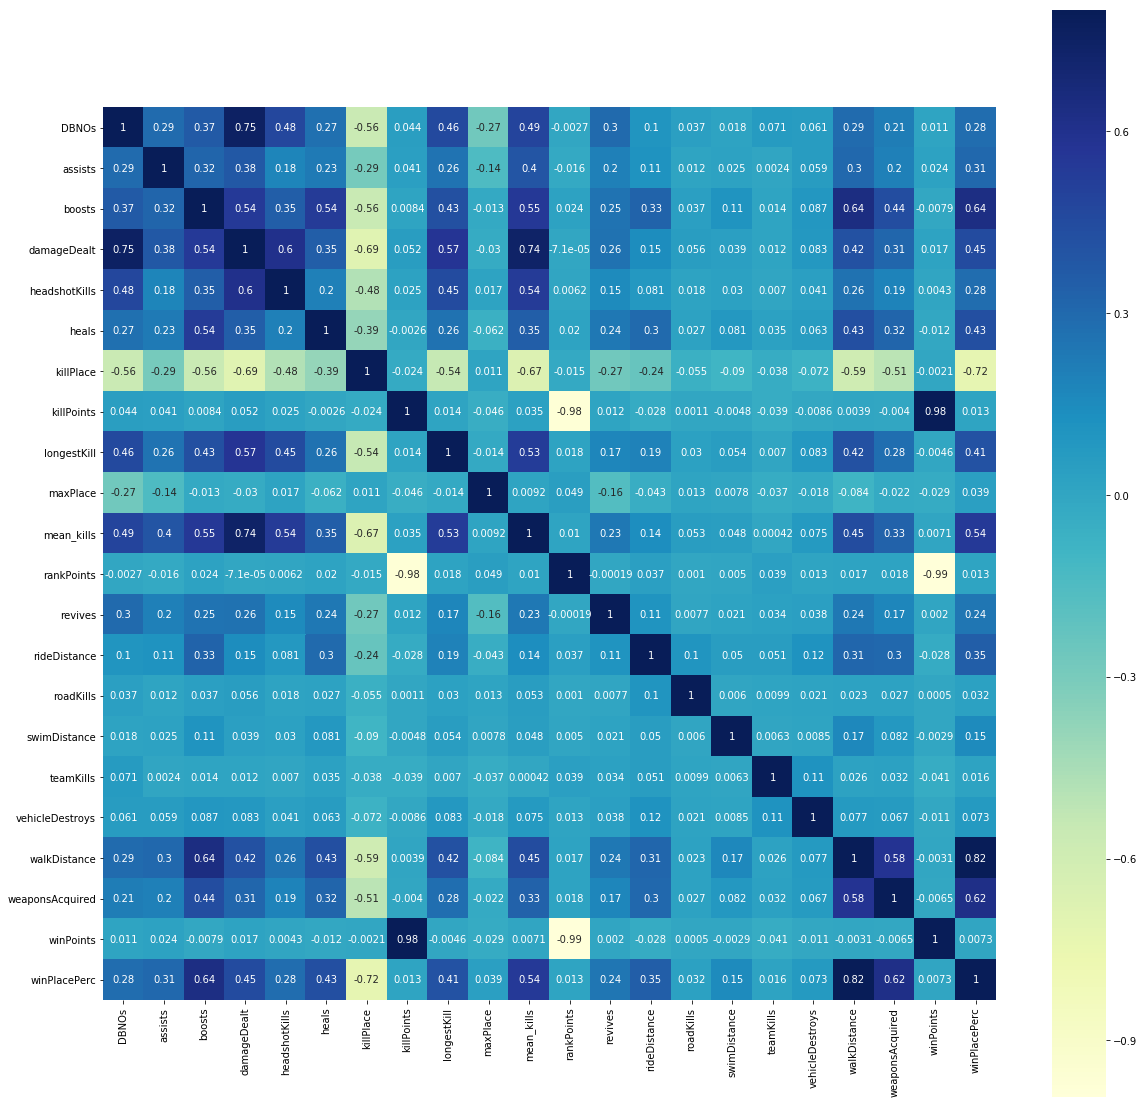

In [67]:
corr = train_df[numeric_features].corr()
f, ax = plt.subplots(figsize = (20,20))

sns.heatmap(corr, vmax=.8, cmap = 'YlGnBu', annot = True, square=True)

In [68]:
high_corr_features = {}
for col in corr.columns:
    high_corr_features.setdefault(col,[])
    for row in corr.index:
        if row != col:
            if abs(corr.loc[row,col]) > 0.7:
                high_corr_features[col].append(row)
                   
corr.winPlacePerc.sort_values(ascending = False)

winPlacePerc       1.000000
walkDistance       0.815324
boosts             0.636865
weaponsAcquired    0.618111
mean_kills         0.544868
damageDealt        0.450858
heals              0.430341
longestKill        0.412739
rideDistance       0.345614
assists            0.305913
DBNOs              0.284474
headshotKills      0.282873
revives            0.242104
swimDistance       0.150988
vehicleDestroys    0.072914
maxPlace           0.038878
roadKills          0.031843
teamKills          0.016473
rankPoints         0.013455
killPoints         0.013299
winPoints          0.007302
killPlace         -0.720743
Name: winPlacePerc, dtype: float64

In [69]:
high_corr_features

{'DBNOs': ['damageDealt'],
 'assists': [],
 'boosts': [],
 'damageDealt': ['DBNOs', 'mean_kills'],
 'headshotKills': [],
 'heals': [],
 'killPlace': ['winPlacePerc'],
 'killPoints': ['rankPoints', 'winPoints'],
 'longestKill': [],
 'maxPlace': [],
 'mean_kills': ['damageDealt'],
 'rankPoints': ['killPoints', 'winPoints'],
 'revives': [],
 'rideDistance': [],
 'roadKills': [],
 'swimDistance': [],
 'teamKills': [],
 'vehicleDestroys': [],
 'walkDistance': ['winPlacePerc'],
 'weaponsAcquired': [],
 'winPoints': ['killPoints', 'rankPoints'],
 'winPlacePerc': ['killPlace', 'walkDistance']}

In [70]:
not_correlated = corr[["winPlacePerc"]][abs(corr.winPlacePerc) <= 0.2].index.tolist()
not_correlated

['killPoints',
 'maxPlace',
 'rankPoints',
 'roadKills',
 'swimDistance',
 'teamKills',
 'vehicleDestroys',
 'winPoints']

In [71]:
train_df = train_df.drop(not_correlated, axis=1)

In [72]:
numeric_features = train_df.select_dtypes(exclude = ["object"]).columns.tolist()

In [73]:
corr = train_df[numeric_features].corr()
corr.shape

(14, 14)

In [74]:
corr = corr.drop("winPlacePerc", axis=1)
corr = corr.drop("winPlacePerc", axis=0)
corr.shape

(13, 13)

In [75]:
vif = pd.DataFrame()  
vif["VIF_Factor"] = [variance_inflation_factor(corr.values,i) for i in range(corr.shape[1])]  
vif["features"] = corr.columns  
vif = vif.sort_values(by = "VIF_Factor", ascending = False)
vif

,VIF_Factor,features
3,117.941835,damageDealt
8,43.599988,mean_kills
6,42.355014,killPlace
0,33.314335,DBNOs
2,25.018916,boosts
11,23.198994,walkDistance
7,9.455004,longestKill
4,8.963560,headshotKills
12,8.405463,weaponsAcquired
5,6.109396,heals


In [76]:
while True:
    features = corr.columns.tolist()
    vif = pd.DataFrame()
    vif["VIF_factor"] = [variance_inflation_factor(corr.values, i) for i in range(len(features))]
    vif["features"] = features
    vif = vif.sort_values(by="VIF_factor", ascending = False)
    features = vif.features.tolist()
    print(features)
    if vif.iloc[0,0] >= 15:
        exceped = features.pop(0)
        corr = train_df[features].corr()
    else:
        break
vif

['damageDealt', 'mean_kills', 'killPlace', 'DBNOs', 'boosts', 'walkDistance', 'longestKill', 'headshotKills', 'weaponsAcquired', 'heals', 'assists', 'rideDistance', 'revives']
['killPlace', 'mean_kills', 'boosts', 'walkDistance', 'DBNOs', 'longestKill', 'weaponsAcquired', 'headshotKills', 'heals', 'assists', 'rideDistance', 'revives']
['boosts', 'walkDistance', 'mean_kills', 'longestKill', 'DBNOs', 'headshotKills', 'weaponsAcquired', 'heals', 'assists', 'rideDistance', 'revives']
['mean_kills', 'walkDistance', 'longestKill', 'DBNOs', 'headshotKills', 'weaponsAcquired', 'heals', 'assists', 'rideDistance', 'revives']


,VIF_factor,features
1,12.238940,mean_kills
0,10.630788,walkDistance
2,6.790427,longestKill
3,6.195475,DBNOs
4,6.092271,headshotKills
5,5.758967,weaponsAcquired
6,3.706930,heals
7,2.827822,assists
8,2.129572,rideDistance
9,2.009738,revives


In [77]:
train_df_X = train_df[features]
test_df_X = test_df[features]
train_df_label = train_df.winPlacePerc
print("train_X_shape : {}, train_label_shape : {} \n test_X_shape : {}".format(train_df_X.shape, train_df_label.shape,test_df_X.shape))

train_X_shape : (4410757, 10), train_label_shape : (4410757,) 
 test_X_shape : (1934174, 10)


In [78]:
%%time
base_Model = OLS(train_df_label, train_df_X).fit()
predictions = base_Model.predict(train_df_X)

CPU times: user 6.37 s, sys: 7.13 s, total: 13.5 s
Wall time: 5.78 s


In [79]:
base_Model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           winPlacePerc   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                 4.088e+06
Date:                Sat, 08 Jun 2019   Prob (F-statistic):               0.00
Time:                        02:09:01   Log-Likelihood:             1.4071e+06
No. Observations:             4410757   AIC:                        -2.814e+06
Df Residuals:                 4410747   BIC:                        -2.814e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
mean_kills          0.0721   9.95e-05    725.264      0.000       0.072       0.072
walkDistance        0.0002   9.82e-08   1569.780      0.000       0.000       0.000
longestKill        -0.0001   2.11e-06    -71.077      0.000      -0.000      -0.000
DBNOs              -0.0040   9.37e-05    -42.199      0.000      -0.004      -0.004
headshotKills      -0.0189      0.000   -104.965      0.000      -0.019      -0.019
weaponsAcquired     0.0510   3.51e-05   1452.805      0.000       0.051       0.051
heals               0.0023   3.65e-05     63.954      0.000       0.002       0.002
assists            -0.0036      0.000    -22.095      0.000      -0.004      -0.003
rideDistance     1.271e-05   6.14e-08    207.045      0.000    1.26e-05    1.28e-05
revives             0.0130      0.000     67.990      0.000       0.013       0.013
==============================================================================
Omnibus:                   906600.528   Durbin-Watson:                   1.331
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         28200501.772
Skew:                          -0.262   Prob(JB):                         0.00
Kurtosis:                      15.376   Cond. No.                     4.56e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

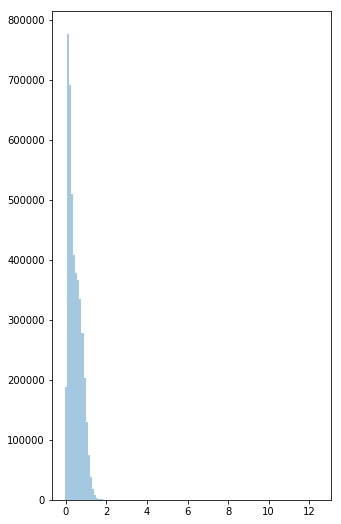

In [80]:
plt.figure(figsize=(5,9))
sns.distplot(predictions, kde = False, bins = 120)

In [81]:
mean_squared_error(predictions, train_df_label)

0.030934207068574058

In [82]:
predictions[predictions >= 1] = 1
mean_squared_error(predictions, train_df_label)

0.027126054648065855

In [95]:
params = {
    "n_estimators" : [100],
    "max_depth" : [3],
    "learning_rate" : [0.1],
    "sub_sample" : [0.7],
    "nthreads" : [-1]
}

In [96]:
xgbmodel = XGBRegressor()
RSCxgb = RandomizedSearchCV(xgbmodel, params, cv=5)

In [97]:
%%time
model = RSCxgb.fit(train_df_X, train_df_label)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(

CPU times: user 48min 15s, sys: 14.5 s, total: 48min 30s
Wall time: 48min 30s


In [98]:
pred_train = model.predict(train_df_X)
mean_squared_error(pred_train, train_df_label)

0.01635977488595739

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


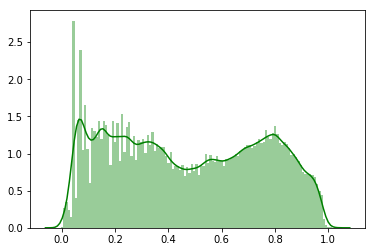

In [99]:
predict = model.predict(test_df_X)
sns.distplot(predict, kde = True, color="green", bins=120)

In [100]:
predict[predict >= 1] = 1

In [101]:
submission = pd.DataFrame({"Id" : test_df.Id,
             "winPlacePerc" : predict})

In [102]:
submission.shape[0] == test_df.shape[0]

True

In [104]:
submission.to_csv("submission.csv", index=False)